In [50]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import requests

# Folium library

We'll be using Folium, a mapping library. You may need to run the following cell (after un-commenting it) and restart the kernel.

In [2]:
#!pip install --user folium

In [3]:
import folium


# Capital Bikeshare Rides Data

Download the [2011 trip data](https://s3.amazonaws.com/capitalbikeshare-data/2011-capitalbikeshare-tripdata.zip) from [Capital Bikeshare](https://www.capitalbikeshare.com/system-data). Don't need to unzip the ZIP file; Pandas will handle it:

In [194]:
#rides = pd.read_csv("../hw6/2011-capitalbikeshare-tripdata.zip")
#ROOT = "/home/cs/data202/CaptialBikeShare/"
ROOT = '../data/capital_bikeshare/'
rides = pd.concat([
    pd.read_csv(
        f"{ROOT}/2019{month:02d}-capitalbikeshare-tripdata.zip",
    usecols=["Duration", "Start date", "End date", "Start station number", "End station number", "Member type"])
    for month in range(1, 11)
])
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3013027 entries, 0 to 337551
Data columns (total 6 columns):
Duration                int64
Start date              object
End date                object
Start station number    int64
End station number      int64
Member type             object
dtypes: int64(3), object(3)
memory usage: 160.9+ MB


In [195]:
print('{:,d}'.format(len(rides)))
rides.head()

3,013,027


,Duration,Start date,End date,Start station number,End station number,Member type
0,230,2019-01-01 00:04:48,2019-01-01 00:08:39,31203,31200,Member
1,1549,2019-01-01 00:06:37,2019-01-01 00:32:27,31321,31114,Casual
2,177,2019-01-01 00:08:46,2019-01-01 00:11:44,31104,31323,Casual
3,228,2019-01-01 00:08:47,2019-01-01 00:12:35,31281,31280,Member
4,1300,2019-01-01 00:12:29,2019-01-01 00:34:10,31014,31923,Member


In [197]:
rides['start_datetime'] = pd.to_datetime(rides['Start date'])
rides['start_hour'] = rides['start_datetime'].dt.hour

# Station Data
Let's get the [info about each station](https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json).

Main things to notice in this section:

* **JSON is a useful format for structured data**.
* The `requests` library is a relatively easy way to automatically fetch data from the Web
* Pandas can make a DataFrame from a list of `dict`s.

In [198]:
station_info_response = requests.get("https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json")
station_info_response_json = station_info_response.json()

In [199]:
stations = pd.DataFrame(station_info_response_json['data']['stations'])

In [200]:
print(len(stations), 'stations')
stations.head()

574 stations


,capacity,eightd_has_key_dispenser,eightd_station_services,electric_bike_surcharge_waiver,external_id,has_kiosk,lat,lon,name,region_id,rental_methods,rental_url,short_name,station_id
0,19,False,[{'id': '5029b3a1-a049-46f9-a13c-c7ffef2bb88c'...,False,08249be7-1f3f-11e7-bf6b-3863bb334450,True,38.902221,-77.059219,Georgetown Harbor / 30th St NW,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31215,72
1,23,False,[{'id': '6944e559-dc16-4a55-9125-e2c3256e294e'...,False,0824aa39-1f3f-11e7-bf6b-3863bb334450,True,38.900283,-77.029822,13th St & New York Ave NW,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31227,91
2,35,False,[{'id': '2a0089f1-ce95-4633-9471-61b0f70b7c08'...,False,0824c80d-1f3f-11e7-bf6b-3863bb334450,True,38.902061,-77.038322,17th & K St NW / Farragut Square,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31233,106
3,14,False,NaN,False,082469cc-1f3f-11e7-bf6b-3863bb334450,True,38.858971,-77.053230,Eads St & 15th St S,41,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31000,1
4,11,False,NaN,False,08246b69-1f3f-11e7-bf6b-3863bb334450,True,38.857250,-77.053320,18th St & S Eads St,41,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31001,2


In [201]:
stations['short_name'] = pd.to_numeric(stations['short_name'])

In [202]:
stations.query('short_name == 31203')

,capacity,eightd_has_key_dispenser,eightd_station_services,electric_bike_surcharge_waiver,external_id,has_kiosk,lat,lon,name,region_id,rental_methods,rental_url,short_name,station_id
26,23,False,NaN,False,08247a21-1f3f-11e7-bf6b-3863bb334450,True,38.9086,-77.0323,14th & Rhode Island Ave NW,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31203,25


# Adding traffic data
By "traffic" I mean ridership by station.


In [12]:
rides['am_pm'] = ["AM" if hour < 12 else "PM" for hour in rides['start_hour']]

In [13]:
traffic_data = pd.merge(
    rides.groupby(['Start station number', 'am_pm']).size().unstack(),
    rides.groupby(['End station number', 'am_pm']).size().unstack(),
    suffixes=["_departures", "_arrivals"],
    left_index=True, right_index=True
)

stations_with_traffic = pd.merge(
    stations,
    traffic_data,
    left_on="short_name", right_index=True,
    how='inner'
)
stations_with_traffic.head()

,capacity,eightd_has_key_dispenser,eightd_station_services,electric_bike_surcharge_waiver,external_id,has_kiosk,lat,lon,name,region_id,rental_methods,rental_url,short_name,station_id,AM_departures,PM_departures,AM_arrivals,PM_arrivals
0,19,False,[{'id': '5029b3a1-a049-46f9-a13c-c7ffef2bb88c'...,False,08249be7-1f3f-11e7-bf6b-3863bb334450,True,38.902221,-77.059219,Georgetown Harbor / 30th St NW,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31215,72,1906.0,8887.0,8186.0,9849.0
1,23,False,[{'id': '6944e559-dc16-4a55-9125-e2c3256e294e'...,False,0824aa39-1f3f-11e7-bf6b-3863bb334450,True,38.900283,-77.029822,13th St & New York Ave NW,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31227,91,2054.0,7481.0,11983.0,5647.0
2,35,False,[{'id': '2a0089f1-ce95-4633-9471-61b0f70b7c08'...,False,0824c80d-1f3f-11e7-bf6b-3863bb334450,True,38.902061,-77.038322,17th & K St NW / Farragut Square,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31233,106,3006.0,9626.0,13523.0,7834.0
3,14,False,NaN,False,082469cc-1f3f-11e7-bf6b-3863bb334450,True,38.858971,-77.053230,Eads St & 15th St S,41,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31000,1,530.0,908.0,223.0,1045.0
4,11,False,NaN,False,08246b69-1f3f-11e7-bf6b-3863bb334450,True,38.857250,-77.053320,18th St & S Eads St,41,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31001,2,525.0,1287.0,295.0,1351.0


# Viewing data on a map

Main things to notice:
* **latitude and longitude** are the main two things you need for displaying map data.
* Geographic data usually needs a **base map** to be useful. Different base maps are useful in different circumstances
* Map data, especially base maps, may be proprietary (needs license keys).

In [14]:
# Try un-commenting the different "tiles" lines, one at a time.
folium.Map(
    location=[42.961111, -85.655556],
    #tiles='Stamen Toner',
    #tiles="CartoDB positron",
    #tiles="CartoDB dark_matter",
    zoom_start=13
)

Now here's how we can add our stations:

In [35]:
m = folium.Map(
    location=[39, -77.],
    tiles='Stamen Toner',
    zoom_start=10
)

for station in stations_with_traffic.itertuples():
    folium.CircleMarker(
        location=[station.lat, station.lon],
        tooltip=station.name,
        fill=True,
        radius=2
    ).add_to(m)

display(m)

# Coloring data by region

We need to manually specify what colors to use. 

We'll pick a color scheme from [ColorBrewer](http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6).

Notice that there are 3 different types of color schemes:
* diverging
* sequential
* qualitative

Note also that we often express colors in hexadecimal (red-green-blue, two hex digits each).

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

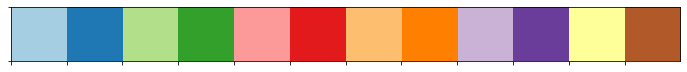

In [36]:
colors = sns.color_palette("Paired")
sns.palplot(colors)
color_codes = colors.as_hex()
color_codes

The `stations` data includes a `region_id`, which looks like it might identify which geographic region a station is in.

In [37]:
stations.region_id.value_counts()

42     302
41      92
44      46
43      36
104     34
40      31
133     23
152     10
Name: region_id, dtype: int64

In [38]:
region_to_color = dict(zip(stations_with_traffic.region_id.unique(), color_codes))
region_to_color

{42: '#a6cee3',
 41: '#1f78b4',
 40: '#b2df8a',
 44: '#33a02c',
 43: '#fb9a99',
 104: '#e31a1c',
 133: '#fdbf6f',
 152: '#ff7f00'}

In [39]:
stations_with_traffic['marker_color'] = stations.region_id.map(region_to_color)

In [42]:
m = folium.Map(
    location=[39, -77.],
    tiles='Stamen Toner',
    zoom_start=10
)

for station in stations_with_traffic.itertuples():
    folium.CircleMarker(
        location=[station.lat, station.lon],
        tooltip=station.name,
        color=station.marker_color,
        radius=2,
        fill=True
    ).add_to(m)

display(m)

# Data organized by regions are useful for analysis

In [21]:
(
    stations_with_traffic
    .groupby('region_id')
    [['AM_departures', 'AM_arrivals', 'PM_departures', 'PM_arrivals']]
    .mean()
    .T
    .style.bar(vmax=6000)
)

region_id,40,41,42,43,44,104,133,152
AM_departures,695.774,880.011,2938.11,138.722,312.261,150.235,70.2609,136.3
AM_arrivals,619.645,779.598,2989.85,137.5,241.065,148.088,69.7826,88.8
PM_departures,1191.23,1649.9,5885.21,228.278,574.022,271.029,174.348,200.3
PM_arrivals,1388.35,1613.37,5875.12,227.083,562.848,264.471,191.087,268.8


# Clustering

What if the data didn't come with `region_id`? We could use *clustering* to discover spatially similar regions.

There are many different kinds of clustering algorithms, but *k-means* is a very common one because it's simple and often works reasonably.


In [22]:
from sklearn.cluster import KMeans

One downside of k-means is we need to tell it how many clusters to look for.

In [23]:
km = KMeans(n_clusters=8)

In [24]:
# We'll use the latitude and longitude as features to cluster by.
# np.c_[] constructs a 2D array from columns.
X = np.c_[
    1.0 * stations_with_traffic['lat'],
    1.0 * stations_with_traffic['lon']
]
X.shape

(572, 2)

In [25]:
# clustering objects have a similar interface to classifiers:
km.fit(X)

stations_with_traffic['kmeans_cluster'] = km.predict(X)

stations_with_traffic['kmeans_cluster'].value_counts()

0    174
3    108
5     76
4     72
7     61
1     36
2     29
6     16
Name: kmeans_cluster, dtype: int64

In [54]:
cluster_to_color = dict(enumerate(color_codes.copy()))
stations_with_traffic['marker_color'] = stations_with_traffic['kmeans_cluster'].map(cluster_to_color)

In [58]:
m = folium.Map(
    location=[39, -77.],
    tiles='Stamen Toner',
    zoom_start=10
)

for station in stations_with_traffic.itertuples():
    folium.CircleMarker(
        location=[station.lat, station.lon],
        tooltip=station.name,
        color=station.marker_color,
        radius=2
    ).add_to(m)

for cluster, cluster_center in enumerate(km.cluster_centers_):
    folium.CircleMarker(
        location=cluster_center,
        radius=10,
        color=mpl.colors.rgb2hex(sns.desaturate(cluster_to_color[cluster], .5)),
        fill=True,
    ).add_to(m)
    
display(m)

In [28]:
(
    stations_with_traffic
    .groupby('kmeans_cluster')
    [['AM_departures', 'AM_arrivals', 'PM_departures', 'PM_arrivals']]
    .mean()
    .T
    .style.bar(width=90)
)

kmeans_cluster,0,1,2,3,4,5,6,7
AM_departures,3737.75,138.722,153.897,1867.99,480.361,889.658,156.812,722.311
AM_arrivals,4176.08,137.5,156.966,1359.07,318.222,765.224,155.688,710.557
PM_departures,8106.59,228.278,281.276,2813,809.264,1605.21,309.875,1445.67
PM_arrivals,7789.32,227.083,274.345,3370.06,746.472,1541.25,306.75,1523.26
